<a href="https://colab.research.google.com/github/namita0210/Fashion-Image-CLassification/blob/main/Fashion_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [22]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

# Load training and Test Data

In [8]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# Create Data Loader Iterable for train and test data

In [9]:
batch_size = 64
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [11]:
for X,y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# Check gpu availability

In [12]:
device =('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using {device} device')

Using cpu device


# Define Neural Network Architecture --> nn.Module

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Set Loss function and Optimizer

In [14]:
learning_rate = 1e-3
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Define Training and Testing Loop

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Perform train and test on actual data from the dataset over a specified # of epochs

In [16]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.308509  [   64/60000]
loss: 2.289287  [ 6464/60000]
loss: 2.271737  [12864/60000]
loss: 2.270911  [19264/60000]
loss: 2.232635  [25664/60000]
loss: 2.219944  [32064/60000]
loss: 2.235966  [38464/60000]
loss: 2.201029  [44864/60000]
loss: 2.199496  [51264/60000]
loss: 2.168530  [57664/60000]
Test Error: 
 Accuracy: 41.3%, Avg loss: 2.158939 

Epoch 2
-------------------------------
loss: 2.172640  [   64/60000]
loss: 2.157214  [ 6464/60000]
loss: 2.101030  [12864/60000]
loss: 2.122090  [19264/60000]
loss: 2.047435  [25664/60000]
loss: 2.007870  [32064/60000]
loss: 2.048027  [38464/60000]
loss: 1.967215  [44864/60000]
loss: 1.972789  [51264/60000]
loss: 1.901362  [57664/60000]
Test Error: 
 Accuracy: 55.6%, Avg loss: 1.895600 

Epoch 3
-------------------------------
loss: 1.927282  [   64/60000]
loss: 1.896892  [ 6464/60000]
loss: 1.778283  [12864/60000]
loss: 1.828236  [19264/60000]
loss: 1.685665  [25664/60000]
loss: 1.656463  [32064/600

# Save the model

In [17]:
torch.save(model.state_dict(), 'model_weights.pth')

# Analyzing the data - Post classification training of the model

In [18]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}


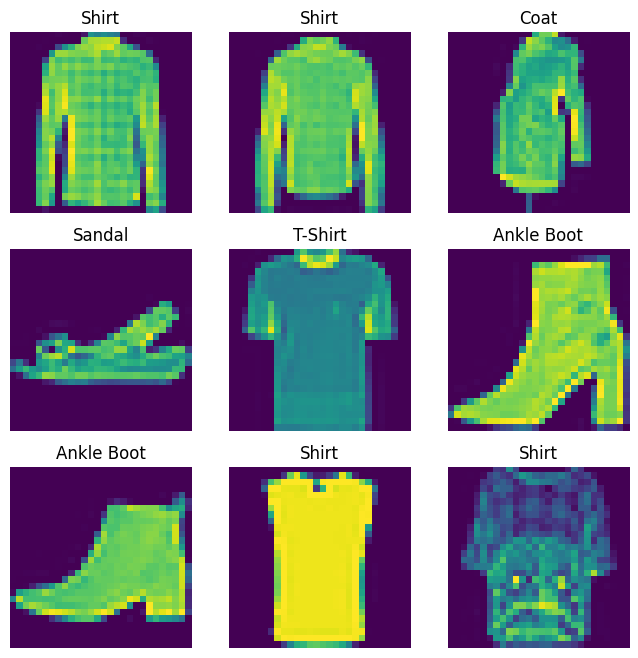

In [23]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
plt.show()

# Evaluating the trained and loaded model on a single item

In [24]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


In [28]:
pred[0]

tensor([-3.7112, -4.2735, -2.5789, -2.7629, -1.8203,  4.8115, -2.2352,  4.4710,
         2.4283,  5.1945])

In [27]:
pred[0].argmax(0)

tensor(9)